In [ ]:
# https://arxiv.org/abs/2410.01201
# were RNNs All We Needed? 

from tqdm import tqdm
import torch
import tiktoken
import urllib.request

enc = tiktoken.get_encoding("gpt2")
url = 'https://raw.githubusercontent.com/karpathy/char-rnn/refs/heads/master/data/tinyshakespeare/input.txt'
filename = 'shakespeare.txt'
urllib.request.urlretrieve(url, filename)

docs = open("shakespeare.txt", "r").read().splitlines()
len(docs)

40000

In [4]:
tokens= set(enc.encode(" ".join(docs)))
tokens_ids = [int(i) for i in tokens]
Vocab = {}
for i in tokens_ids:
    token = enc.decode([i])
    Vocab[token] = i
vocab_size = len(Vocab)
print(vocab_size)


11387


In [5]:
block_size = 64 # context length: how many tokens do we take to predict the next one?

def build_dataset(docs):  
    X, Y = [], []
  
    for doc in docs:
        context = [0] * block_size
        for token in doc:
            ix = Vocab.get(token)
            if ix is None:
                continue  # skip token if it's not in the vocabulary
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X, dtype=torch.long)
    Y = torch.tensor(Y, dtype=torch.long)
    print(f"X shape: {X.shape}, Y shape: {Y.shape}")
    return X, Y

n = int(len(docs) * 0.9)
Xtr, Ytr = build_dataset(docs[:n])
Xte, Yte = build_dataset(docs[n:])

X shape: torch.Size([978353, 64]), Y shape: torch.Size([978353])
X shape: torch.Size([95053, 64]), Y shape: torch.Size([95053])


In [ ]:
n_embd = 10
hidden_size = 256
block_size = 64
batch_size = 32 

g = torch.Generator().manual_seed(983245) # for reproducibility
C = torch.randn((vocab_size, n_embd),                   generator=g)
# Parameters for the first minGRU layer
Zt1_W  = torch.randn((block_size * n_embd, hidden_size), generator=g) * (1)/((block_size * n_embd)**0.5)
Zt1_B  = torch.randn (hidden_size                      , generator=g) * 0 
Ht1_W  = torch.randn((block_size * n_embd, hidden_size), generator=g) * (1)/((block_size * n_embd)**0.5)
Ht1_B  = torch.randn(hidden_size                       , generator=g) * 0

# Parameters for the second min GRU layer
Zt2_W = torch.randn((hidden_size, hidden_size),         generator=g) * (1)/((hidden_size)**0.5) # input-to-gate
Zt2_B = torch.randn(hidden_size,                        generator=g) * 0
Ht2_W = torch.randn((hidden_size, hidden_size),         generator=g) * (1)/((hidden_size)**0.5) # input-to-candidate
Ht2_B = torch.randn(hidden_size,                        generator=g) * 0
W     = torch.randn((hidden_size, vocab_size),          generator=g) * 0.01
B     = torch.randn(vocab_size) * 0


# BatchNorm parameters
bngain = torch.ones((1, hidden_size))
bnbias = torch.zeros((1, hidden_size))
bnmean_running = torch.zeros((1, hidden_size))
bnstd_running = torch.ones((1, hidden_size))

bngain2 = torch.ones((1, hidden_size))
bnbias2 = torch.zeros((1, hidden_size))
bnmean_running2 = torch.zeros((1, hidden_size))
bnstd_running2 = torch.ones((1, hidden_size))

parameters = [C, Zt1_W, Zt1_B, Ht1_W, Ht1_B, Zt2_W, Zt2_B, Ht2_W, Ht2_B, W, B, bngain, bnbias, bngain2, bnbias2]
print(f"Total number of parameters: {sum(p.nelement() for p in parameters)}") # number of parameters in total
for p in parameters:
  p.requires_grad = True




Total number of parameters: 3501129


In [ ]:
max_steps = 100000
lossi = []

loss_fn = torch.nn.CrossEntropyLoss()
# x_t: (batch_size, input_size)
# h_prev: (batch_size, hidden_size)
for step in tqdm(range(max_steps), desc='Training Progress', unit=' steps'):
    minibatch = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[minibatch], Ytr[minibatch]
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    Ztpreact = embcat @ Zt1_W + Zt1_B
    Htilde = embcat @ Ht1_W + Ht1_B 

    bnmeani = Ztpreact.mean(0, keepdim=True)
    bnstdi = Ztpreact.std(0, keepdim=True)
    Ztpreact = bngain * (Ztpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi 
        
    Zt =  torch.sigmoid(Ztpreact) 
    H1_t = (1-Zt) * torch.zeros_like(Zt) + Zt * Htilde # first hidden state | output from the first minGRU layer
    
    # second layer
    Ztpreact2 = H1_t @ Zt2_W + Zt2_B
    
    bnmeani2 = Ztpreact.mean(0, keepdim=True)
    bnstdi2 = Ztpreact.std(0, keepdim=True)
    Ztpreact2 = bngain2 * (Ztpreact2 - bnmeani2) / bnstdi2 + bnbias2
    with torch.no_grad():
        bnmean_running2 = 0.999 * bnmean_running2 + 0.001 * bnmeani2
        bnstd_running2 = 0.999 * bnstd_running2 + 0.001 * bnstdi2

    Zt2 = torch.sigmoid(Ztpreact2)
    Htilde2 = H1_t @ Ht2_W + Ht2_B
    H2_t = (1 - Zt2) * H1_t + Zt2 * Htilde2
    
    # linear layer  
    outputs = H2_t @ W + B 
    loss = loss_fn(outputs.view(-1, vocab_size), Yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if step < 50000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if step % 5000 == 0:
        tqdm.write(f'Step {step}, Loss: {loss.item()}')
    if step % 1000 == 0:
        lossi.append(loss.item())

print(f"Final Loss: {lossi[-1]}")


Training Progress:   0%|          | 11/100000 [00:00<29:48, 55.91 steps/s]

Step 0, Loss: 9.33500862121582


Training Progress:   5%|▌         | 5009/100000 [01:15<21:53, 72.31 steps/s]

Step 5000, Loss: 2.1451380252838135


Training Progress:  10%|█         | 10013/100000 [02:40<22:04, 67.96 steps/s] 

Step 10000, Loss: 1.7346588373184204


Training Progress:  15%|█▌        | 15011/100000 [03:51<19:33, 72.45 steps/s]

Step 15000, Loss: 1.464119553565979


Training Progress:  20%|██        | 20011/100000 [05:01<18:39, 71.44 steps/s]

Step 20000, Loss: 2.1823103427886963


Training Progress:  25%|██▌       | 25008/100000 [06:28<16:52, 74.03 steps/s]

Step 25000, Loss: 1.5935108661651611


Training Progress:  30%|███       | 30011/100000 [07:43<15:17, 76.28 steps/s]

Step 30000, Loss: 1.4746524095535278


Training Progress:  35%|███▌      | 35007/100000 [08:56<17:44, 61.06 steps/s]

Step 35000, Loss: 1.3238582611083984


Training Progress:  40%|████      | 40007/100000 [10:19<19:46, 50.57 steps/s]

Step 40000, Loss: 2.0624313354492188


Training Progress:  45%|████▌     | 45015/100000 [11:48<12:39, 72.39 steps/s]

Step 45000, Loss: 1.115250825881958


Training Progress:  50%|█████     | 50005/100000 [12:57<11:01, 75.57 steps/s]

Step 50000, Loss: 1.4705991744995117


Training Progress:  55%|█████▌    | 55015/100000 [14:07<09:47, 76.56 steps/s]

Step 55000, Loss: 1.5026473999023438


Training Progress:  60%|██████    | 60010/100000 [15:14<08:38, 77.15 steps/s]

Step 60000, Loss: 1.2411000728607178


Training Progress:  65%|██████▌   | 65011/100000 [16:22<07:48, 74.74 steps/s]

Step 65000, Loss: 1.2024791240692139


Training Progress:  70%|███████   | 70012/100000 [17:31<06:33, 76.24 steps/s]

Step 70000, Loss: 1.5710220336914062


Training Progress:  75%|███████▌  | 75009/100000 [18:39<05:59, 69.50 steps/s]

Step 75000, Loss: 1.961722731590271


Training Progress:  80%|████████  | 80010/100000 [19:58<04:53, 68.10 steps/s]

Step 80000, Loss: 1.356242060661316


Training Progress:  85%|████████▌ | 85014/100000 [21:09<03:26, 72.41 steps/s]

Step 85000, Loss: 1.6090885400772095


Training Progress:  90%|█████████ | 90013/100000 [22:37<02:36, 63.67 steps/s]

Step 90000, Loss: 1.305763602256775


Training Progress:  95%|█████████▌| 95009/100000 [23:50<01:11, 69.43 steps/s]

Step 95000, Loss: 1.2014031410217285


Training Progress: 100%|██████████| 100000/100000 [25:03<00:00, 66.51 steps/s]

Final Loss: 1.9817931652069092


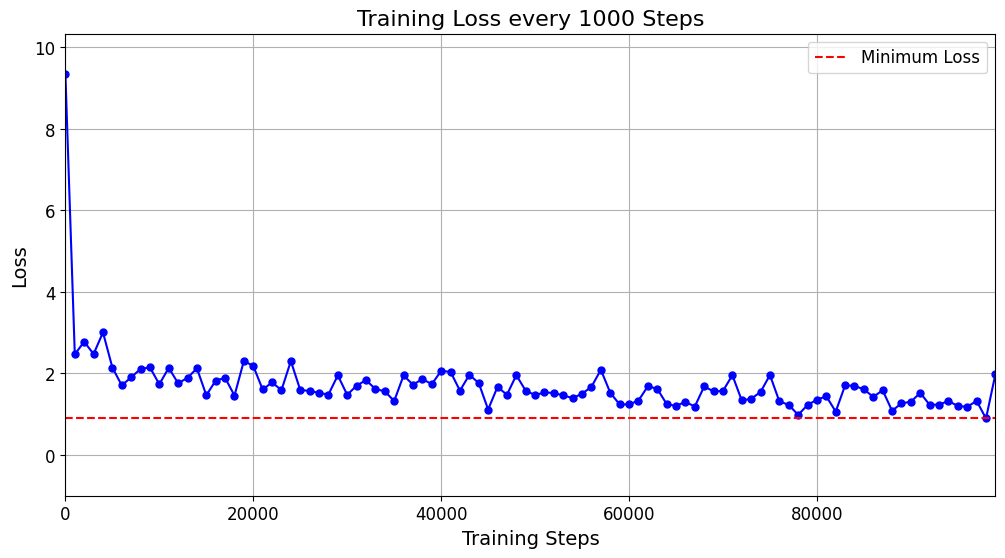

In [28]:
import matplotlib.pyplot as plt



steps = list(range(0, len(lossi) * 1000, 1000))  # Assuming loss is recorded every 1000 steps

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(steps, lossi, marker='o', color='b', linestyle='-', markersize=5)
plt.title('Training Loss every 1000 Steps', fontsize=16)
plt.xlabel('Training Steps', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xlim(0, max(steps))
plt.ylim(-1, max(lossi) + 1)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(y=min(lossi), color='r', linestyle='--', label='Minimum Loss')
plt.legend(fontsize=12)
plt.show() 

In [ ]:
with torch.no_grad():
    emb = C[Xte]
    embcat = emb.view(emb.shape[0], -1)
    # Forward pass for the first GRU layer
    Ztpreact = embcat @ Zt1_W + Zt1_B
    Htilde = embcat @ Ht1_W + Ht1_B
    # Batch normalization for the first layer
    bnmeani = Ztpreact.mean(0, keepdim=True)
    bnstdi = Ztpreact.std(0, keepdim=True)
    Ztpreact = bngain * (Ztpreact - bnmeani) / bnstdi + bnbias
    # Update running statistics
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi   
    Zt = torch.sigmoid(Ztpreact)
    H1_t = (1 - Zt) * torch.zeros_like(Zt) + Zt * Htilde  # Using zeros for h_prev initially
    # Forward pass for the second GRU layer
    Ztpreact2 = H1_t @ Zt2_W + Zt2_B
    bnmeani2 = Ztpreact2.mean(0, keepdim=True)
    bnstdi2 = Ztpreact2.std(0, keepdim=True)
    Ztpreact2 = bngain2 * (Ztpreact2 - bnmeani2) / bnstdi2 + bnbias2
    # Update running statistics for second layer
    bnmean_running2 = 0.999 * bnmean_running2 + 0.001 * bnmeani2
    bnstd_running2 = 0.999 * bnstd_running2 + 0.001 * bnstdi2
    Zt2 = torch.sigmoid(Ztpreact2)
    Htilde2 = H1_t @ Ht2_W + Ht2_B
    H2_t = (1 - Zt2) * H1_t + Zt2 * Htilde2
    # Compute outputs
    outputs = H2_t @ W + B 
    # Compute the loss for the entire test dataset
    loss_fn = torch.nn.CrossEntropyLoss()
    loss = loss_fn(outputs.view(-1, vocab_size), Yte)

    print(f"Test Loss: {loss.item()}")

